# Math 168 Final Project: Network-Driven Approach to Music Recommendation Using Spotify Data

Kristian Kieffer, Bridget Bidwell, Izzy Zoeller, Megan Mitchell

Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tqdm.auto import tqdm
from __future__ import annotations
import ast
from pathlib import Path
from typing import Literal
from sklearn.preprocessing import MinMaxScaler
import statistics
import plotly.express as px
import plotly.graph_objects as go
import string
from plotly.subplots import make_subplots

### 1. Load Dataset
Our dataset consists of 98,340 songs. Each song also has values for audio features including danceability, energy, valence, acousticness, instrumentalness, and more.  

Number of songs in dataset: 98340


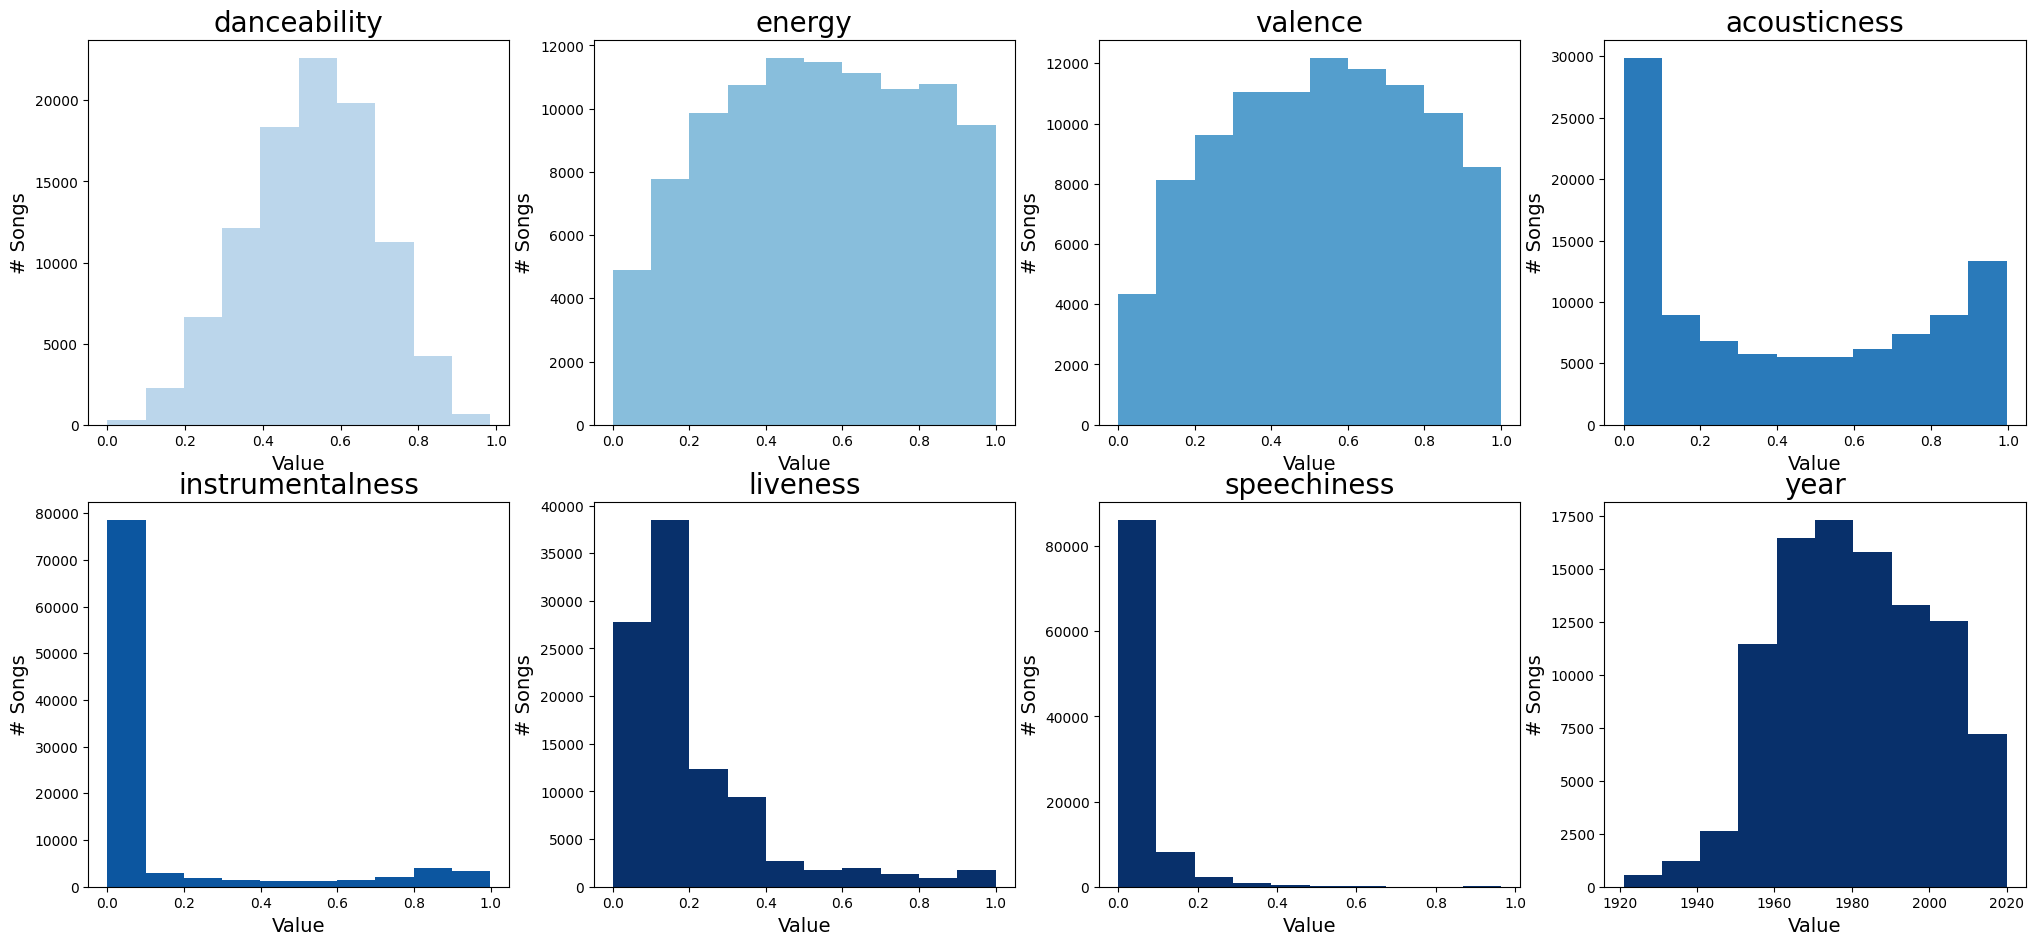

In [ ]:
DATA_PATH   = '/content/drive/MyDrive/Networks Project S.25/MoreData/Copy of v7_full_music_data_with_genres.csv'
df = pd.read_csv(DATA_PATH)

# select features to analyze
features = np.array(["danceability", "energy", "valence","acousticness", "instrumentalness", "liveness", "speechiness", "year"])
fig, axes = plt.subplots(2, 4, figsize=(25,11))


# histogram of feature values

cmap = plt.get_cmap("Blues", 8)
colors = np.array([cmap(i) for i in range(0, 10)][2:10])
features = features.reshape(2,4)

for i in range(0,2):
    for j in range(0,4):
        feature = features[i][j]
        ax = axes[i][j]
        dat = df[feature]
        ax.hist(dat, color=colors[4*i + j])
        ax.set_title(feature, fontsize=20)
        ax.set_ylabel("# Songs", fontsize=14)
        ax.set_xlabel("Value", fontsize=14)

print(f"Number of songs in dataset: {len(df)}")

### 2. Draw Stratified Random Sample to Construct Network

Because our dataset is so large, it is computationally inefficient to try to compute pairwise similarity scores between all of our songs. Instead, we draw a stratified random sample of a certain number of songs (for our report, we used 7,000). Using a SRS ensures that all of the song genres are represented proportionally in our sample.

In [ ]:
# simple random sample (srs) code
# input number of songs to sample, output to a csv

OUTPUT_PATH = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/5-7k-SRS.csv'
SAMPLE_SIZE = 7000

# make decade column
df['decade'] = (df['year'] // 10) * 10

# calc desired sample size by genre/decade proportion
strata_counts = df.groupby(['song_genre','decade']).size()
proportions  = strata_counts / len(df)
target_counts = (proportions * SAMPLE_SIZE).round().astype(int)


# some rounding
diff = SAMPLE_SIZE - target_counts.sum()
if diff > 0:
    # add one to the strata with largest fractional remainders
    frac = (proportions * SAMPLE_SIZE) - (proportions * SAMPLE_SIZE).astype(int)
    for idx in frac.nlargest(diff).index:
        target_counts[idx] += 1
elif diff < 0:
    # remove one from the strata with smallest fractional remainders
    frac = (proportions * SAMPLE_SIZE) - (proportions * SAMPLE_SIZE).astype(int)
    for idx in frac.nsmallest(-diff).index:
        target_counts[idx] -= 1

# take stratified sample
chunks = []
for (genre, decade), n in target_counts.items():
    group = df[(df['song_genre']==genre) & (df['decade']==decade)]
    take  = min(n, len(group))
    if take > 0:
        chunks.append(group.sample(n=take, random_state=42))

sampled = pd.concat(chunks)

if len(sampled) < SAMPLE_SIZE:
    remaining = SAMPLE_SIZE - len(sampled)
    rest      = df.drop(sampled.index)
    sampled   = pd.concat([sampled, rest.sample(n=remaining, random_state=42)])

sampled = sampled.sample(frac=1, random_state=42).reset_index(drop=True)
sampled = sampled.drop(columns=['decade'])

# output to csv
sampled.to_csv(OUTPUT_PATH, index=False)
print(f"Stratified sample of {len(sampled)} songs saved to:\n{OUTPUT_PATH}")


Stratified sample of 7000 songs saved to:
/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/5-7k-SRS.csv


### 3. Define Similarity Measure
To construct the network, we used a custom function that computes the similarity between two songs based on a weighted combination of selected audio features. This similarity score can be used to immediately get song recommendations from an input, but it can also be used to construct a network by connecting two songs that have a similarity above a certain threshold.

In [ ]:
# NEW ALGORITHM

DATA_PATH = '/content/drive/MyDrive/Networks Project S.25/MoreData/Copy of v7_full_music_data_with_genres.csv'

TAU_YEAR       = 55.0
TAU_TEMPO      = 30.0
TAU_LOUDNESS   = 6.4

W_GENRE = 0.00            # weight for genre --> here we set to 0
W_POP   = 0.00            # weight for popularity --> here we set to 0


FEATURE_WEIGHTS = {
    'year':             0.30,
    'energy':           0.15,
    'danceability':     0.15,
    'valence':          0.10,
    'acousticness':     0.10,
    'instrumentalness': 0.10,
    'speechiness':      0.05,
    'tempo':            0.05,
    'loudness':         0.02,
    'liveness':         0.02
}


# Continuous features on [0,1]
CONT_FEATS = [
    'danceability', 'energy', 'valence', 'acousticness',
    'instrumentalness', 'liveness', 'speechiness'
]

# Exponent values for similarity formula (1 - |x - y|)^k
EXPONENTS = {
  'danceability':4.116,
  'energy':2.251,
  'valence': 2.302,
  'acousticness': 1.59,
  'instrumentalness': 87.918,
  'liveness': 6.377,
  'speechiness': 39.488
}

# Load data
df = pd.read_csv(DATA_PATH)
df.set_index('songs_id', inplace=True)

# Precompute normalized popularity
df['popularity_norm'] = df['popularity'] / 100.0

def get_top_similar_with_attrs(query_id, K=20):
    q = df.loc[query_id]
    # Query attributes for display
    query_attrs = q[
        ['song_title (censored)', 'artist_names', 'song_genre', 'year', 'popularity']
        + CONT_FEATS
        + ['tempo', 'loudness', 'popularity_norm']
    ].to_frame().T

    # Genre match (binary)
    s_genre = (df['song_genre'] == q['song_genre']).astype(float)

    # Year‐decay
    s_year = np.exp(-np.abs(df['year'] - q['year']) / TAU_YEAR)

    # populatrty (linear difference)
    s_pop = 1.0 - np.abs(df['popularity_norm'] - q['popularity_norm'])

    # Start building similarity
    sims = W_GENRE * s_genre + W_POP * s_pop + FEATURE_WEIGHTS['year'] * s_year

    # Continuous [0,1] features with exponentiated similarity
    for feat in CONT_FEATS:
        k = EXPONENTS.get(feat, 1.0)
        diff = (df[feat] - q[feat]).abs().fillna(1.0)  # if NaN, treat as max difference
        sim_cont = (1.0 - diff).clip(lower=0.0) ** k
        sims += FEATURE_WEIGHTS[feat] * sim_cont

    # Tempo with exponential‐decay
    s_tempo = np.exp(-np.abs(df['tempo'] - q['tempo']) / TAU_TEMPO)
    sims += FEATURE_WEIGHTS['tempo'] * s_tempo

    # Loudness with exponential‐decay
    s_loud = np.exp(-np.abs(df['loudness'] - q['loudness']) / TAU_LOUDNESS)
    sims += FEATURE_WEIGHTS['loudness'] * s_loud

    # Exclude query, pick top K
    sims = sims.drop(query_id, errors='ignore')
    top_ids = sims.nlargest(K).index

    # Build result DataFrame
    result = df.loc[top_ids, [
            'song_title (censored)', 'artist_names', 'song_genre', 'year',
            'popularity'
        ] + CONT_FEATS + ['tempo', 'loudness', 'popularity_norm']
    ].copy()
    result['similarity'] = sims.loc[top_ids].values

    result = result.reset_index().rename(columns={'index': 'songs_id'})
    return query_attrs.reset_index().rename(columns={'index': 'songs_id'}), result

# example usage
example_id = 715871	  #715871 Yellow 178663 Paradise City GNR 363196 So What MD 621642 All I need 499450 Beautiful Day U2 (GREAT) 408990 Shimmer 214027 JazzArtist 652171 Hotel Cali
# 515914 Rockaway Beach Ramones 204088 Calication RHCP
query_info, top20 = get_top_similar_with_attrs(example_id, K=30)

from IPython.display import display, Markdown
display(Markdown("**Query Song Attributes:**"))
display(query_info)
display(Markdown("**Top 20 Similar Songs:**"))
display(top20)


**Query Song Attributes:**

,songs_id,song_title (censored),artist_names,song_genre,year,popularity,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness,popularity_norm
0,715871,Yellow,['Coldplay'],Pop/Rock,2000,51,0.429,0.661,0.285,0.00239,0.00013,0.234,0.0281,173.365,-7.227,0.51


**Top 20 Similar Songs:**

,songs_id,song_title (censored),artist_names,song_genre,year,popularity,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness,popularity_norm,similarity
0,673759,Yellow,['Coldplay'],Pop/Rock,2000,81,0.429,0.661,0.285,0.002390,0.000130,0.2340,0.0281,173.365,-7.227,0.81,1.040000
1,827529,Burn,['Jo Dee Messina'],Country,2000,34,0.430,0.708,0.356,0.133000,0.000000,0.2380,0.0351,173.706,-6.804,0.34,0.972835
2,526873,Colorful,['The Verve Pipe'],Pop/Rock,2001,44,0.442,0.646,0.238,0.037900,0.000520,0.0902,0.0307,161.637,-5.370,0.44,0.963595
3,385400,**** Day,['Shinedown'],Pop/Rock,2005,46,0.429,0.688,0.370,0.000084,0.000000,0.1020,0.0309,174.019,-5.563,0.46,0.962182
4,197712,The ***** Between,['Dave Matthews Band'],Pop/Rock,2001,59,0.406,0.730,0.207,0.047100,0.000000,0.2290,0.0315,170.032,-6.278,0.59,0.958460
5,644457,45,['Shinedown'],Pop/Rock,2003,67,0.446,0.657,0.215,0.002200,0.000000,0.1890,0.0262,152.132,-4.494,0.67,0.954934
6,825404,All the Love in the World,['The Corrs'],Pop/Rock,2000,56,0.461,0.695,0.309,0.195000,0.000001,0.1310,0.0293,179.609,-7.623,0.56,0.951657
7,124350,Never Die,['Creed'],Pop/Rock,1999,39,0.429,0.617,0.280,0.001930,0.000245,0.0845,0.0269,87.982,-4.668,0.39,0.949037
8,416711,Sister Christian,['Night Ranger'],Pop/Rock,2000,39,0.431,0.562,0.256,0.108000,0.000006,0.1280,0.0384,177.579,-8.553,0.39,0.946215
9,822188,Push,['Matchbox Twenty'],Pop/Rock,1996,71,0.420,0.672,0.476,0.006700,0.000000,0.1080,0.0270,168.019,-7.902,0.71,0.945541


### 4. Create an edge list for network construction

Using our sampled dataset, we compute the similarity scores between every song in the dataframe and draw an edge between two song that have a similarity above a certain threshold.

In [ ]:
# create an edge csv for community detection

SAMPLE_PATH    = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/5-7k-SRS.csv'
EDGE_LIST_PATH = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/6.96.1-Edges.csv'
SIM_THRESHOLD  = 0.96

# Decay constants
TAU_YEAR       = 55.0
TAU_TEMPO      = 41.0
TAU_LOUDNESS   = 6.4

# Weights for each feature in the final similarity sum (needs to sum to 1)
FEATURE_WEIGHTS = {
    'year':             0.30,
    'energy':           0.15,
    'danceability':     0.15,
    'valence':          0.10,
    'acousticness':     0.10,
    'instrumentalness': 0.10,
    'speechiness':      0.05,
    'tempo':            0.05,
    'loudness':         0.02,
    'liveness':         0.02
}


# Continuous features → power exponents k_m so that (1 - σ_m)^k_m = 0.5
EXPONENTS = {
  'danceability':4.116,
  'energy':2.251,
  'valence': 2.302,
  'acousticness': 1.592,
  'instrumentalness': 87.918,
  'liveness': 6.377,
  'speechiness': 39.488
}

# List of those continuous [0,1] columns
CONT_FEATS = [
    'danceability', 'energy', 'valence', 'acousticness',
    'instrumentalness', 'liveness', 'speechiness'
]

df = pd.read_csv(SAMPLE_PATH)
df.set_index('songs_id', inplace=True)

# Pre‐extract numpy arrays for speed
ids       = df.index.to_numpy()
years     = df['year'].to_numpy()
tempo_arr = df['tempo'].to_numpy()
loud_arr  = df['loudness'].to_numpy()

# Array of continuous features
cont_arr  = df[CONT_FEATS].to_numpy()

# edge list
edges = []
n = len(df)

for i in range(n):
    # Year similarity (exponential decay)
    sy = np.exp(-np.abs(years - years[i]) / TAU_YEAR)
    sim = FEATURE_WEIGHTS['year'] * sy

    # Continuous features [0,1] with power‐law similarity
    diffs = np.abs(cont_arr - cont_arr[i])  # shape (n, len(CONT_FEATS))
    for idx, feat in enumerate(CONT_FEATS):
        k = EXPONENTS[feat]
        # (1 - |x - y|)^k, clipped so negative differences don’t arise
        sim_cont = np.clip(1.0 - diffs[:, idx], 0.0, 1.0) ** k
        sim += FEATURE_WEIGHTS[feat] * sim_cont

    # Tempo similarity (exponential decay on absolute BPM difference)
    s_tempo = np.exp(-np.abs(tempo_arr - tempo_arr[i]) / TAU_TEMPO)
    sim += FEATURE_WEIGHTS['tempo'] * s_tempo

    # Loudness similarity (exponential decay on dB difference)
    s_loud = np.exp(-np.abs(loud_arr - loud_arr[i]) / TAU_LOUDNESS)
    sim += FEATURE_WEIGHTS['loudness'] * s_loud

    # Identify neighbors above threshold
    neighbors = np.where(sim > SIM_THRESHOLD)[0]
    for j in neighbors:
        if j > i:  # avoid duplicates and self‐links
            edges.append((ids[i], ids[j]))

# save edgelist csv
edge_df = pd.DataFrame(edges, columns=['source', 'target'])
edge_df.to_csv(EDGE_LIST_PATH, index=False)
print(f"Saved {len(edge_df)} edges to {EDGE_LIST_PATH}")


Saved 717 edges to /content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/6.96.1-Edges.csv


In [ ]:
# Network construction using similarity

SAMPLE_CSV = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/5-7k-SRS.csv'
EDGE_CSV   = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/6.96.1-Edges.csv'
songs_df = pd.read_csv(SAMPLE_CSV)
edges_df = pd.read_csv(EDGE_CSV)

# build undirected graph
G = nx.Graph()
for _, row in songs_df.iterrows():
    G.add_node(row['songs_id'],
               genre=row['song_genre'],
               year=row['year'],
               popularity=row['popularity'])
G.add_edges_from(edges_df[['source','target']].itertuples(index=False, name=None))


NameError: name 'nx' is not defined

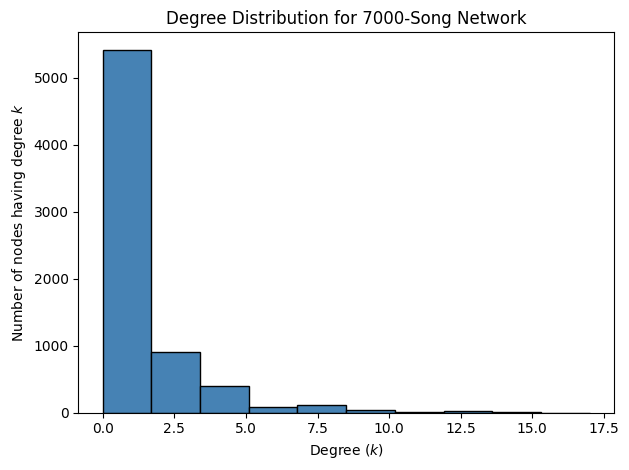

In [ ]:
# degree distribution figure
plt.hist([d for g, d in G.degree()], color="steelblue", edgecolor="black")
plt.title("Degree Distribution for 7000-Song Network")
plt.xlabel("Degree ($k$)")
plt.ylabel("Number of nodes having degree $k$")


plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Networks Project S.25/song_network_degree_distribution.png', dpi=300)

### 5. Community detection to generate "playlists"
We can use Louvain community detection to generate communities of similar songs. By controlling the resolution parameter of community detection, we can create communities of a certain size in order to create playlists that all have a distinct set of audio features.

In [ ]:
# run louvain community detection
communities = nx.community.louvain_communities(G, weight=None, resolution=1, seed=42)
# Build partition dict: node -> community id
partition = {}
for cid, comm in enumerate(communities):
    for node in comm:
        partition[node] = cid

# Attach community labels
songs_df['community'] = songs_df['songs_id'].map(partition)


comm_sizes = songs_df['community'].value_counts().sort_index()
top_genres = songs_df.groupby('community')['song_genre'] \
                    .agg(lambda s: s.value_counts().idxmax())
numeric_feats = ['year','danceability','energy',
                 'valence','acousticness','instrumentalness',
                 'liveness','speechiness','tempo','loudness']
centroids = songs_df.groupby('community')[numeric_feats].mean()

# Display tables
print(comm_sizes.reset_index().rename(columns={'index':'community','community':'size'}))
print(top_genres.reset_index().rename(columns={'song_genre':'top_genre'}))
print(centroids.reset_index())

      size  count
0        0      1
1        1      1
2        2      1
3        3      1
4        4      1
...    ...    ...
6326  6326      1
6327  6327      1
6328  6328      1
6329  6329      1
6330  6330      1

[6331 rows x 2 columns]
      community       top_genre
0             0  Stage & Screen
1             1        Pop/Rock
2             2           Latin
3             3       Classical
4             4        Pop/Rock
...         ...             ...
6326       6326        Pop/Rock
6327       6327        Pop/Rock
6328       6328        Pop/Rock
6329       6329        Pop/Rock
6330       6330         Country

[6331 rows x 2 columns]
      community    year  danceability  energy  valence  acousticness  \
0             0  1966.0         0.136   0.484   0.1020      0.715000   
1             1  1972.0         0.734   0.824   0.9700      0.196000   
2             2  1998.0         0.515   0.613   0.5880      0.812000   
3             3  1953.0         0.171   0.186   0.0396      0.

In [ ]:
SAMPLE_CSV = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/5-7k-SRS.csv'
EDGE_CSV   = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/6.96.1-Edges.csv'

songs_df = pd.read_csv(SAMPLE_CSV)   # must include song_id, title, artist
edges_df = pd.read_csv(EDGE_CSV)     # must include source,target columns

# build graph
G = nx.Graph()
# add nodes with metadata
for _, row in songs_df.iterrows():
    G.add_node(row['songs_id'],
               title=row.get('song_title (censored)', row.get('song_title', None)),
               artist=row.get('artist_names', row.get('artist', None)))
# add edges
G.add_edges_from(edges_df[['source','target']]
                       .itertuples(index=False, name=None))

# compute centralities
# pick any or multiple measures:
deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G, k=None, weight=None, seed=42)
cls_cent = nx.closeness_centrality(G)
eig_cent = nx.eigenvector_centrality(G, max_iter=200)

# package into a DataFrame
df_cent = pd.DataFrame({
    'song_id':    list(deg_cent.keys()),
    'degree':     list(deg_cent.values()),
    'betweenness':list(btw_cent.values()),
    'closeness':  list(cls_cent.values()),
    'eigenvector':list(eig_cent.values()),
})

# merge in titles & artists
df_cent = df_cent.merge(
    songs_df[['songs_id','song_title (censored)','artist_names']],
    left_on='song_id', right_on='songs_id'
).drop(columns=['songs_id'])

# display top 10 for every metric
K = 10
for metric in ['degree','betweenness','closeness','eigenvector']:
    topk = (df_cent[['song_id','song_title (censored)','artist_names',metric]]
               .sort_values(metric, ascending=False)
               .head(K))
    print(f"\nTop {K} by {metric} centrality:")
    print(topk.to_string(index=False))



Top 10 by degree centrality:
 song_id                     song_title (censored)            artist_names   degree
  406996 I've Only Myself to Blame - 78rpm Version           ['Doris Day'] 0.001000
  920249                                 Dangerous            ['Loverboy'] 0.000857
  676862                               **** Velvet        ['Bobby Vinton'] 0.000857
  131417                     Wait Till You See Him      ['Blossom Dearie'] 0.000857
  639711                                Galway Bay           ['Sam Cooke'] 0.000857
  662736                         Prelude To A Kiss     ['Ella Fitzgerald'] 0.000714
  919850         That's When Your Heartaches Begin       ['Elvis Presley'] 0.000714
  965957                            **** Came Back ['Theory of a Deadman'] 0.000714
  215749                    Best Days of Your Life      ['Kellie Pickler'] 0.000714
  805462                                    Devour           ['Disturbed'] 0.000572

Top 10 by betweenness centrality:
 song_id   

In [ ]:
# import packages for radar plots

# rename communities using letters
comm_names = dict(zip(top_10_df['community'], list(string.ascii_uppercase)[:len(top_10_df['community'])]))

# choose features to represent on radar plot
feats = ['year',  'danceability', 'energy', 'valence',  'acousticness', 'instrumentalness', 'liveness', 'speechiness',  'tempo',  'loudness']

# scale df
scaled_df = top_10_df.copy()
for f in feats:
  scaled_df[f] = (scaled_df[f] - scaled_df[f].min()) / (scaled_df[f].max() - scaled_df[f].min())

# make subplots
fig = make_subplots(rows=3, cols=3, subplot_titles=[f'Community  {i}' for i in comm_names.values()], specs=[[{"type": "polar"}]*3]*3)

for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.03  # Adjust value as needed (e.g., 0.02 to 0.05)

for i in scaled_df.index[0:9]:
  radar_plot = go.Scatterpolar(r = [scaled_df.loc[i][f] for f in feats], theta=[f[0:4]+"." for f in feats], fill="toself")
  fig.add_trace(radar_plot, row = (i // 3) + 1, col = (i % 3) + 1)
  fig.update_layout(
    {f'polar{i+1}': dict(
      radialaxis=dict(
        visible=False
      ),
    )},
    showlegend=False
  )

fig.update_layout(height = 800, width=800, showlegend=False)

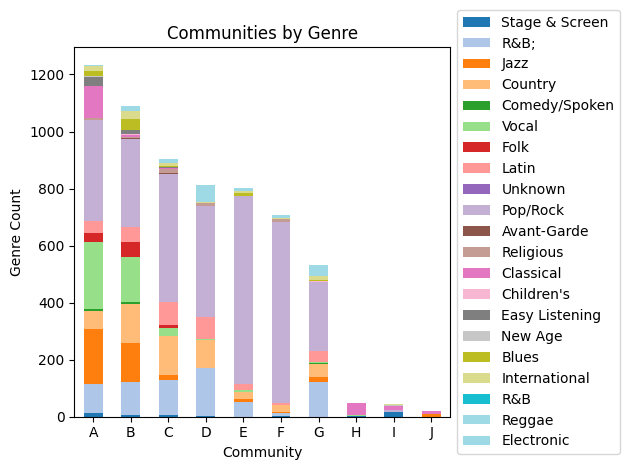

In [ ]:
# stacked bar chart-->analyze community genre
songs_df.set_index('songs_id', inplace=True)
genres = set(songs_df['song_genre'])
portions = {}
for i in range(0, len(communities)):
  community = list(communities[i])
  genre_portion = {}
  community_size = len(community)
  if community_size > 10:
    community_genres = [songs_df.loc[a]['song_genre'] for a in community]
    for genre in genres:
      genre_portion[genre] = community_genres.count(genre)
    portions[i] = genre_portion


genre_df = pd.DataFrame.from_dict(portions)
genre_df = genre_df.rename(columns=comm_names).reindex(columns=list(string.ascii_uppercase)[:len(genre_df.columns)])


genre_df.transpose().plot(kind='bar', stacked=True, legend=False, colormap='tab20')

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Communities by Genre')
plt.xticks(rotation=0)
plt.xlabel("Community")
plt.ylabel("Genre Count")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Networks Project S.25/communities_by_genre.png', dpi=300)

In [ ]:
# Compute modularity given partition
nx.community.modularity(G, communities)

0.6050122709938942

In [ ]:
# find top artists by community

def top_artist(i):
  c = communities[i]
  artists = []
  for song in c:
    artists.append(songs_df.loc[song]['artist_names'])

  max_artist = max(set(artists), key=lambda a: artists.count(a))
  return max_artist, artists.count(max_artist)

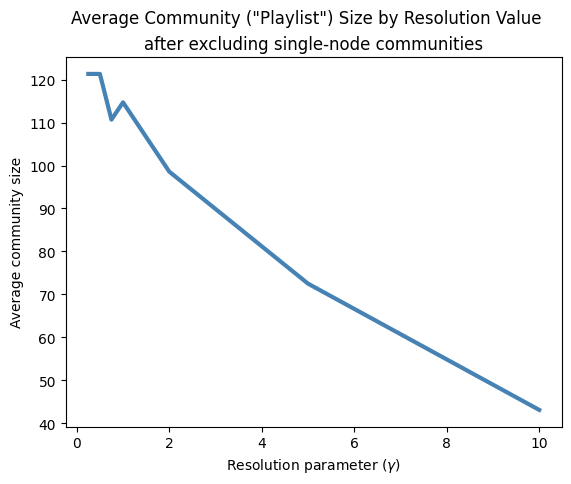

In [ ]:
# avg community size by resolution
def avg_community_size(G, r):
  communities = nx.community.louvain_communities(G, weight=None, resolution=r, seed=42)
  sizes = np.array([len(c) for c in communities])
  final_sizes = sizes[np.where(sizes > 1)]
  return np.average(final_sizes)

res_vals = [0.25, 0.5, 0.75, 1, 2, 5, 10, 30, 50]
comm_sizes = [avg_community_size(G, r) for r in res_vals]
plt.plot(res_vals, comm_sizes, linewidth=3, color='steelblue')
plt.suptitle("Average Community (\"Playlist\") Size by Resolution Value")
plt.title("after excluding single-node communities")
plt.xlabel("Resolution parameter ($\gamma$)")
plt.ylabel("Average community size")
plt.savefig('/content/drive/MyDrive/Networks Project S.25/Community_size_by_resolution.png', dpi=300)

In [ ]:
# larger the resolution, smaller the community sizes
# find smaller communities, build a function that prioritizes a few audio features and puts out the playlist with the highest average of those two priorized audio features

In [ ]:
from networkx.algorithms.community import louvain_communities

# run Louvain
communities = louvain_communities(G, weight=None, resolution=30, seed=42)

# filter out singleton communities
filtered_communities = [comm for comm in communities if len(comm) > 1]

# build the partition dict from the filtered communities
partition = {node: cid for cid, comm in enumerate(filtered_communities) for node in comm}

# assign community labels only to non-singletons
songs_df['community'] = songs_df.index.map(partition)


# count singleton communities (only one node)
num_singleton_communities = sum(1 for comm in communities if len(comm) == 1)

print(f"Number of singleton communities: {num_singleton_communities}")


In [ ]:
# check average community size
community_sizes = songs_df['community'].value_counts()
average_size = community_sizes.mean()
print(f"Average community size: {average_size:.2f}")


In [ ]:
num_communities = len(community_sizes)
print(f"Number of communities: {num_communities}")


In [ ]:
# get communities with 10-20 songs
community_sizes = songs_df['community'].value_counts()
target_comms = community_sizes[(community_sizes >= 10) & (community_sizes <= 30)].index
filtered_df = songs_df[songs_df['community'].isin(target_comms)]

# count unique communities in filtered_df
remaining_communities = filtered_df['community'].nunique()

print(f"Number of remaining communities (sizes 10-20): {remaining_communities}")



In [ ]:
# compute modularity
nx.community.modularity(G, communities)

In [ ]:
# average audio features for each community
avg_audio = filtered_df.groupby('community')[numeric_feats].mean().reset_index()

avg_audio_norm = avg_audio.copy()

# normalize tempo, loudness, valence
to_normalize = ['tempo', 'loudness', 'valence']  # Add more if needed
avg_audio_norm[to_normalize] = MinMaxScaler().fit_transform(avg_audio[to_normalize])



In [ ]:
avg_audio_norm['party_score'] = (
    avg_audio_norm['danceability'] +
    avg_audio_norm['energy'] +
    avg_audio_norm['valence'] +
    avg_audio_norm['loudness']
) / 4

best_party_comm = avg_audio_norm.sort_values('party_score', ascending=False).iloc[0]['community']

party_playlist = filtered_df[filtered_df['community'] == best_party_comm]
party_playlist

In [ ]:
avg_audio_norm['study_score'] = (
    avg_audio_norm['instrumentalness'] +
    avg_audio_norm['acousticness'] +
    (1 - avg_audio_norm['speechiness']) +
    (1 - avg_audio_norm['danceability']) +
    (1 - avg_audio_norm['energy'])
) / 5
best_study_comm = avg_audio.sort_values('study_score', ascending=False).iloc[0]['community']
study_playlist = filtered_df[filtered_df['community'] == best_study_comm]
study_playlist

In [ ]:
avg_audio_norm['sleep_score'] = (
    avg_audio_norm['instrumentalness'] +
    avg_audio_norm['acousticness'] +
    (1 - avg_audio_norm['speechiness']) +
    (1 - avg_audio_norm['energy']) +
    (1 - avg_audio_norm['tempo']) +
    (1 - avg_audio_norm['valence'])
) / 6

best_sleep_comm = avg_audio_norm.sort_values('sleep_score', ascending=False).iloc[0]['community']
sleep_playlist = filtered_df[filtered_df['community'] == best_sleep_comm]
sleep_playlist

In [ ]:
avg_audio_norm['chill_score'] = (
    avg_audio_norm['instrumentalness'] +
    avg_audio_norm['acousticness'] +
    (1 - avg_audio_norm['energy']) +
    (1 - avg_audio_norm['tempo'])
) / 4
best_chill_comm = avg_audio.sort_values('chill_score', ascending=False).iloc[0]['community']
chill_playlist = filtered_df[filtered_df['community'] == best_chill_comm]
chill_playlist

In [ ]:
avg_audio_norm['sad_score'] = (
    (1 - avg_audio_norm['valence']) +
    (1 - avg_audio_norm['energy']) +
    (1 - avg_audio_norm['tempo']) +
    avg_audio_norm['acousticness']
) / 4
best_sad_comm = avg_audio_norm.sort_values('sad_score', ascending=False).iloc[0]['community']
sad_playlist = filtered_df[filtered_df['community'] == best_sad_comm]
sad_playlist

### 6. Use similarity metrics to give song recommendations based on input song

In [ ]:
# Similarity Functions

# cosine similarity
def cosine_similarity(A, source_node):
  # degree of node i
  node_i = source_node
  ki = nx.degree(A, nbunch = node_i)

  similarities = []
  for node_j in A.nodes():
      if node_j != node_i:
        # get degree of node j
        kj = nx.degree(A, nbunch = node_j)
        # get number of common neighbors
        n = len(nx.common_neighbors(A, node_i, node_j))

        # cosine similarity
        try:
          cos_sim = n / math.sqrt(ki*kj)
        except:
          cos_sim = 0
        similarities.append((cos_sim, node_j))

  return sorted(similarities)[::-1]

# Jaccard similarity
def jaccard_similarity(A, source_node):
  node_i = source_node
  # degree of node i
  ki = nx.degree(A, nbunch = node_i)

  similarities = []
  for node_j in A.nodes():
    if node_j != node_i:
      # get degree of node j
      kj = nx.degree(A, nbunch = node_j)
      # get number of common neighbors
      n = len(nx.common_neighbors(A, node_i, node_j))

      # jaccard similarity
      jacc_sim = n / (ki + kj - n)
      similarities.append((jacc_sim, node_j))

  return sorted(similarities)[::-1]

# define matrix for katz similarity
# Katz similarity
node_list = G.nodes()
A = nx.adjacency_matrix(G, nodelist = node_list)
inv = np.linalg.inv(np.identity(len(G.nodes)) - 0.25*A)

# Katz similarity
def katz_similarity(A, katz_mat, source_node):
  similarities = []
  idx_source = list(node_list).index(source_node)
  for node_j in node_list:
    if node_j != source_node:
      idx_target = list(node_list).index(node_j)
      similarities.append((katz_mat[idx_target][idx_source], node_j))

  return sorted(similarities)[::-1]

KeyboardInterrupt: 

In [ ]:
# recommend songs based on an input
def print_top_n_similar(U, source, n):
  df = songs_df.set_index('songs_id')
  cos_sim = [a[1] for a in cosine_similarity(U, source)[0:n]]
  jaccard_sim = [a[1] for a in jaccard_similarity(U, source)[0:n]]
  katz_sim = [a[1] for a in katz_similarity(G, inv, source)[0:n]]
  sim_df = pd.DataFrame.from_dict({"Cosine Similarity": [(df.loc[c]['song_title (censored)'][0:10] + ", " + df.loc[c]['artist_names'].split('\'')[1] + ", " + df.loc[c]['song_genre']) for c in cos_sim],
                               "Jaccard Similarity": [(df.loc[c]['song_title (censored)'][0:10] + ", " + df.loc[c]['artist_names'].split('\'')[1]  + ", " + df.loc[c]['song_genre']) for c in jaccard_sim],
                               "Katz Similarity": [(df.loc[c]['song_title (censored)'][0:10] + ", " + df.loc[c]['artist_names'].split('\'')[1] + ", " + df.loc[c]['song_genre']) for c in katz_sim]})
  print(sim_df)

In [ ]:
# Input: Cornelia Street by Taylor Swift
print_top_n_similar(G, 318295, 5)

                    Cosine Similarity                  Jaccard Similarity  \
0    Never Seen, The Script, Pop/Rock    Never Seen, The Script, Pop/Rock   
1     It's Your , Tim McGraw, Country  Beautiful , Lana Del Rey, Pop/Rock   
2          Si Me Tení, Mijares, Latin     It's Your , Tim McGraw, Country   
3  Beautiful , Lana Del Rey, Pop/Rock  Meet Me in, Harry Styles, Pop/Rock   
4  Meet Me in, Harry Styles, Pop/Rock          Si Me Tení, Mijares, Latin   

                                  Katz Similarity  
0                      River Lea, Adele, Pop/Rock  
1                    Meditation, Laraaji, New Age  
2                   When I Die, Ed Bruce, Country  
3  Piano Conc, Wolfgang Amadeus Mozart, Classical  
4                       Quality Ti, Hi-Five, R&B;  


In [ ]:
# Input: All of You by Miles Davis
print_top_n_similar(G, 327255, 5)

                       Cosine Similarity  \
0          Sweet Sue,, Miles Davis, Jazz   
1          Stand by M, Ben E. King, R&B;   
2  If You Onl, Little Jimmy Scott, Vocal   
3  Carribean , Cannonball Adderley, Jazz   
4      I Mean You, Thelonious Monk, Jazz   

                           Jaccard Similarity  \
0               Sweet Sue,, Miles Davis, Jazz   
1       If You Onl, Little Jimmy Scott, Vocal   
2       Carribean , Cannonball Adderley, Jazz   
3  Tujhse Nar, Lata Mangeshkar, International   
4               Stand by M, Ben E. King, R&B;   

                                  Katz Similarity  
0                    All Cried , Full Force, R&B;  
1  Symphony N, Wolfgang Amadeus Mozart, Classical  
2  Symphony N, Wolfgang Amadeus Mozart, Classical  
3             Tomorrow's, Black Sabbath, Pop/Rock  
4  Clarinet C, Wolfgang Amadeus Mozart, Classical  


In [ ]:
# analyze betweenness centrality
betweenness = nx.betweenness_centrality(G, k=1000)

In [ ]:
sorted_betweenness = dict(sorted(betweenness.items(), key=lambda item: item[1], reverse=True))

### 7. Adapting the Similarity Measure

In [ ]:
DATA_PATH   = '/content/drive/MyDrive/Networks Project S.25/MoreData/Copy of v7_full_music_data_with_genres.csv'
OUTPUT_PATH = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/4.1-5k-SRS-no-poprock.csv'
SAMPLE_SIZE = 8000

# dataset except Pop/Rock
df = pd.read_csv(DATA_PATH)
df = df[df['song_genre'] != 'Pop/Rock'].copy()  # remove all Pop/Rock entries

# new decade column
df['decade'] = (df['year'] // 10) * 10

# calc desired sample size by genre/decade proportion
strata_counts = df.groupby(['song_genre','decade']).size()
proportions  = strata_counts / len(df)
target_counts = (proportions * SAMPLE_SIZE).round().astype(int)

# some rounding
diff = SAMPLE_SIZE - target_counts.sum()
if diff > 0:
    # Add one to strata with largest fractional remainders
    frac = (proportions * SAMPLE_SIZE) - (proportions * SAMPLE_SIZE).astype(int)
    for idx in frac.nlargest(diff).index:
        target_counts[idx] += 1
# elif diff < 0
    # Remove one from strata with smallest fractional remainders
    frac = (proportions * SAMPLE_SIZE) - (proportions * SAMPLE_SIZE).astype(int)
    for idx in frac.nsmallest(-diff).index:
        target_counts[idx] -= 1

# srs, no Pop/Rock
chunks = []
for (genre, decade), n in target_counts.items():
    group = df[(df['song_genre'] == genre) & (df['decade'] == decade)]
    take = min(n, len(group))
    if take > 0:
        chunks.append(group.sample(n=take, random_state=42))

sampled = pd.concat(chunks) if chunks else pd.DataFrame(columns=df.columns)

if len(sampled) < SAMPLE_SIZE:
    remaining = SAMPLE_SIZE - len(sampled)
    rest      = df.drop(sampled.index)
    sampled   = pd.concat([sampled, rest.sample(n=remaining, random_state=42)])

sampled = sampled.sample(frac=1, random_state=42).reset_index(drop=True)
sampled = sampled.drop(columns=['decade'])

# export csv
sampled.to_csv(OUTPUT_PATH, index=False)
print(f"Stratified sample (no Pop/Rock) of {len(sampled)} songs saved to:\n{OUTPUT_PATH}")


Stratified sample (no Pop/Rock) of 5000 songs saved to:
/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/4.1-5k-SRS-no-poprock.csv


In [ ]:
# Get top Katz song per community
top_katz_by_community = songs_df.sort_values('katz', ascending=False).groupby('community').head(1)

community_sizes = songs_df['community'].value_counts().rename_axis('community').reset_index(name='size')
top_katz_by_community = top_katz_by_community.merge(community_sizes, on='community', how='left')

# Label the top 10 largest communities A-J
import string
community_sizes_10 = community_sizes.head(10)
labels = dict(zip(community_sizes_10['community'], list(string.ascii_uppercase[:10])))
top_katz_by_community['community_label'] = top_katz_by_community['community'].map(labels)

top_katz_by_community = top_katz_by_community.sort_values('katz', ascending=False)

KeyError: 'katz'

In [ ]:
# cosine, euclidean, manhatten

CSV_PATH   = "/content/drive/MyDrive/Networks Project S.25/MoreData/Copy of v7_full_music_data_with_genres.csv"
TAU_YEAR   = 40.0   # yrs  → e^−1 drop
TAU_TEMPO  = 41.0   # BPM → e^−1 drop
TAU_LOUD   = 6.4    # dB  → e^−1 drop
TOP_K_DEF  = 10

COL_TITLE  = "song_title (censored)"
COL_ARTIST = "artist_names"
COL_GENRE  = "song_genre"

WEIGHTS = np.array([
    0.25,  # year sim
    0.12,  # tempo_sim
    0.06,  # loudness_sim
    0.13,  # energy
    0.13,  # danceability
    0.09,  # valence
    0.09,  # acousticness
    0.09,  # instrumentalness_sqrt
    0.04,  # speechiness_sqrt
    0.02,  # liveness
])

_df: pd.DataFrame | None = None
STATIC_COLS = [
    "energy", "danceability", "valence", "acousticness",
    "instrumentalness_sqrt", "speechiness_sqrt", "liveness",
]
STATIC_WEIGHTS = WEIGHTS[3:]

def _first_artist(s: str) -> str:
    s = str(s).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            lst = ast.literal_eval(s)
            if isinstance(lst, list) and lst:
                return str(lst[0]).strip()
        except Exception:
            pass
    return s


def load_dataset(path: str | Path = CSV_PATH) -> pd.DataFrame:
    global _df
    if _df is not None:
        return _df
    df = pd.read_csv(path)
    df[COL_ARTIST] = df[COL_ARTIST].apply(_first_artist)
    df["tempo"]    = df["tempo"].clip(lower=40)
    df["loudness"] = df["loudness"].clip(upper=0)
    df["instrumentalness_sqrt"] = np.sqrt(df["instrumentalness"].clip(lower=0))
    df["speechiness_sqrt"]      = np.sqrt(df["speechiness"].clip(lower=0))
    _df = df
    return df


def find_similar(
    title: str,
    artist: str,
    *,
    k: int = TOP_K_DEF,
    metric: Literal["cosine", "euclidean", "manhattan"] = "cosine",
    tau_year: float = TAU_YEAR,
    tau_tempo: float = TAU_TEMPO,
    tau_loud: float = TAU_LOUD,
    csv_path: str | Path = CSV_PATH,
) -> pd.DataFrame:
    """Return top‑k similar songs using the chosen *metric* (cosine|euclidean|manhattan)."""

    df = load_dataset(csv_path)

    mask = (df[COL_TITLE] == title) & (df[COL_ARTIST] == artist)
    if not mask.any():
        raise ValueError("Track not found – check spelling/casing.")
    idx_q = mask.idxmax()

    year_q, tempo_q, loud_q = df.loc[idx_q, ["year", "tempo", "loudness"]]

    rec_sim   = np.exp(-np.abs(df["year"].to_numpy(float)    - year_q)  / tau_year)
    tempo_sim = np.exp(-np.abs(df["tempo"].to_numpy(float)   - tempo_q) / tau_tempo)
    loud_sim  = np.exp(-np.abs(df["loudness"].to_numpy(float) - loud_q) / tau_loud)

    stat_mat = df[STATIC_COLS].to_numpy(float) * STATIC_WEIGHTS

    cand_mat = np.column_stack((
        rec_sim * WEIGHTS[0], tempo_sim * WEIGHTS[1], loud_sim * WEIGHTS[2], stat_mat
    ))

    v_q = np.array([
        WEIGHTS[0], WEIGHTS[1], WEIGHTS[2],
        * (df.loc[idx_q, STATIC_COLS].to_numpy(float) * STATIC_WEIGHTS),
    ])

    if metric == "cosine":
        dots  = cand_mat @ v_q
        norms = np.linalg.norm(cand_mat, axis=1) * np.linalg.norm(v_q)
        sims  = np.divide(dots, norms, out=np.zeros_like(dots), where=norms != 0)
    elif metric == "euclidean":
        dist = np.linalg.norm(cand_mat - v_q, axis=1)
        sims = 1 / (1 + dist)  # higher = closer
    elif metric == "manhattan":
        dist = np.abs(cand_mat - v_q).sum(axis=1)
        sims = 1 / (1 + dist)
    else:
        raise ValueError("metric must be 'cosine', 'euclidean', or 'manhattan'")

    sims[idx_q] = -np.inf
    top_idx = np.argpartition(-sims, k)[:k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    cols = [
        COL_TITLE, COL_ARTIST, COL_GENRE,
        "year", "tempo", "loudness",
        "energy", "danceability", "valence",
        "acousticness", "instrumentalness", "speechiness", "liveness",
    ]

    return (df.loc[top_idx, cols]
              .rename(columns={COL_TITLE: "title", COL_ARTIST: "artist"})
              .assign(similarity=np.round(sims[top_idx], 3))
              .reset_index(drop=True))

if __name__ == "__main__":
    for m in ("cosine", "manhattan"):
        print(f"\nMetric: {m}")
        print(find_similar("Blitzkrieg Bop - **** Remaster", "The Ramones", k = 20, metric=m), "\n")



Metric: cosine
                                                title           artist  \
0                      Blitzkrieg Bop - **** Remaster      The Ramones   
1   I Don't Wanna Go Down to the ******** - **** R...      The Ramones   
2   I Don't Wanna Go Down to the ******** - **** R...      The Ramones   
3                        Running Free - **** Remaster      Iron Maiden   
4                    Milk and Alcohol - **** Remaster     Dr. Feelgood   
5   I Don't Wanna Walk Around with You - **** Rema...      The Ramones   
6   I Don't Wanna Walk Around with You - **** Rema...      The Ramones   
7                                Window Shop for Love           Wipers   
8                           Loudmouth - **** Remaster      The Ramones   
9                           Loudmouth - **** Remaster      The Ramones   
10                                            Hey Joe     Jimi Hendrix   
11                                          I'm a Man         Jobriath   
12                    

In [ ]:
# new algorithm

# use sample for directo comparison to network approach
DATA_PATH = '/content/drive/MyDrive/Networks Project S.25/MoreData/Stratified Sampling CSVs for Comm Detection/5-7k-SRS.csv'

TAU_YEAR       = 55.0     # keeps the same year‐decay from before
TAU_TEMPO      = 30.0    # you can adjust this for tempo, keep it the same
TAU_LOUDNESS   = 6.4     # you can adjust this for loudness

W_GENRE = 0.00            # weight for binary genre match
W_POP   = 0.00            # weight for popularity


FEATURE_WEIGHTS = {
    'year':             0.30,
    'energy':           0.15,
    'danceability':     0.15,
    'valence':          0.10,
    'acousticness':     0.10,
    'instrumentalness': 0.10,
    'speechiness':      0.05,
    'tempo':            0.05,
    'loudness':         0.02,
    'liveness':         0.02
}


# Continuous features on [0,1]
CONT_FEATS = [
    'danceability', 'energy', 'valence', 'acousticness',
    'instrumentalness', 'liveness', 'speechiness'
]

# Exponent values for similarity formula (1 - |x - y|)^k


EXPONENTS = {
  'danceability':4.116,
  'energy':2.251,
  'valence': 2.302,
  'acousticness': 60,#1.59,
  'instrumentalness': 87.918,
  'liveness': 6.377,
  'speechiness': 39.488
}

# Load data
df = pd.read_csv(DATA_PATH)
df.set_index('songs_id', inplace=True)

# Precompute normalized popularity
df['popularity_norm'] = df['popularity'] / 100.0

def get_top_similar_with_attrs(query_id, K=20):
    q = df.loc[query_id]
    # Query attributes for display
    query_attrs = q[
        ['song_title (censored)', 'artist_names', 'song_genre', 'year', 'popularity']
        + CONT_FEATS
        + ['tempo', 'loudness', 'popularity_norm']
    ].to_frame().T

    # Genre match (binary)
    s_genre = (df['song_genre'] == q['song_genre']).astype(float)

    # Year‐decay
    s_year = np.exp(-np.abs(df['year'] - q['year']) / TAU_YEAR)

    # Popularity (linear difference)
    s_pop = 1.0 - np.abs(df['popularity_norm'] - q['popularity_norm'])

    # Start building similarity
    sims = W_GENRE * s_genre + W_POP * s_pop + FEATURE_WEIGHTS['year'] * s_year

    # Continuous [0,1] features with exponentiated similarity
    for feat in CONT_FEATS:
        k = EXPONENTS.get(feat, 1.0)
        diff = (df[feat] - q[feat]).abs().fillna(1.0)  # if NaN, treat as max difference
        sim_cont = (1.0 - diff).clip(lower=0.0) ** k
        sims += FEATURE_WEIGHTS[feat] * sim_cont

    # Tempo with exponential‐decay
    s_tempo = np.exp(-np.abs(df['tempo'] - q['tempo']) / TAU_TEMPO)
    sims += FEATURE_WEIGHTS['tempo'] * s_tempo

    # Loudness with exponential‐decay
    s_loud = np.exp(-np.abs(df['loudness'] - q['loudness']) / TAU_LOUDNESS)
    sims += FEATURE_WEIGHTS['loudness'] * s_loud

    # Exclude query, pick top K
    sims = sims.drop(query_id, errors='ignore')
    top_ids = sims.nlargest(K).index

    # Build result DataFrame
    result = df.loc[top_ids, [
            'song_title (censored)', 'artist_names', 'song_genre', 'year',
            'popularity'
        ] + CONT_FEATS + ['tempo', 'loudness', 'popularity_norm']
    ].copy()
    result['similarity'] = sims.loc[top_ids].values

    result = result.reset_index().rename(columns={'index': 'songs_id'})
    return query_attrs.reset_index().rename(columns={'index': 'songs_id'}), result

# Example usage
example_id = 327255	  #715871 Yellow 178663 Paradise City GNR 363196 So What MD 621642 All I need 499450 Beautiful Day U2 (GREAT) 408990 Shimmer 214027 JazzArtist 652171 Hotel Cali
# 515914 Rockaway Beach Ramones 204088 Calication RHCP
query_info, top20 = get_top_similar_with_attrs(example_id, K=20)

from IPython.display import display, Markdown
display(Markdown("**Query Song Attributes:**"))
display(query_info)
display(Markdown("**Top 20 Similar Songs:**"))
display(top20)


**Query Song Attributes:**

,songs_id,song_title (censored),artist_names,song_genre,year,popularity,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness,popularity_norm
0,327255,All of You,['Miles Davis'],Jazz,1955,7,0.656,0.271,0.559,0.426,0.000065,0.277,0.0413,82.449,-10.353,0.07


**Top 20 Similar Songs:**

,songs_id,song_title (censored),artist_names,song_genre,year,popularity,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness,popularity_norm,similarity
0,156000,Stand by Me,['Ben E. King'],R&B;,1962,61,0.632,0.232,0.673,0.428,0.000005,0.2150,0.0318,119.136,-12.326,0.61,0.877871
1,217013,"Sweet Sue, Just You - first version",['Miles Davis'],Jazz,1955,5,0.646,0.323,0.462,0.675,0.000001,0.2320,0.0439,80.173,-7.633,0.05,0.874889
2,427717,I Mean You (Take 4),"['Thelonious Monk', 'Gerry Mulligan', 'Wilbur ...",Jazz,1957,6,0.634,0.286,0.563,0.793,0.000116,0.1070,0.0342,80.831,-14.237,0.06,0.871890
3,849088,Harlem Nocturne,['Louis Prima'],Jazz,1957,12,0.671,0.132,0.609,0.404,0.002560,0.1180,0.0413,86.487,-15.010,0.12,0.842800
4,684055,I Let A Song Go Out Of My Heart,"['Dizzy Gillespie', 'Stan Getz']",Jazz,1955,18,0.618,0.270,0.576,0.874,0.001570,0.0910,0.0352,108.429,-12.825,0.18,0.840558
5,955719,Soho - **** Remaster,"['Bert Jansch', 'John Renbourn']",Folk,1966,30,0.565,0.263,0.494,0.416,0.000113,0.1080,0.0365,80.105,-15.327,0.30,0.837104
6,511199,The More I See You - Rudy Van Gelder Edition,['Hank Mobley'],Jazz,1960,19,0.656,0.285,0.612,0.875,0.003170,0.0908,0.0478,80.197,-13.205,0.19,0.836759
7,533212,Solidarity Forever,['Pete Seeger'],Folk,1955,16,0.722,0.321,0.541,0.972,0.000000,0.2310,0.0354,108.337,-10.016,0.16,0.836690
8,262533,If You Only Knew,['Little Jimmy Scott'],Vocal,1955,11,0.667,0.345,0.647,0.312,0.000000,0.3330,0.0377,120.330,-8.494,0.11,0.836193
9,502390,Carribean Cutie (Alternate),['Cannonball Adderley'],Jazz,1955,8,0.603,0.296,0.683,0.673,0.002390,0.2000,0.0389,80.001,-12.288,0.08,0.835132


In [ ]:
#  Benchmark “weighted-sum” algorithm on 5 000 random seeds
#  - draws SAMPLE_SIZE seeds without replacement
#  - for each seed, calls get_top_similar_with_attrs(…, K=20)
#  - counts how many of the 20 neighbours share the seed’s genre
#  - aggregates by genre → average hit-ratio and #seeds

SAMPLE_SIZE = 100        # number of seeds
K_NEIGHBORS = 10          # top-k list size
RANDOM_SEED = 43          # reproducibility

assert 'df' in globals(), "Run the algorithm cell first (df must exist)."

rng = random.Random(RANDOM_SEED)
seed_idx = rng.sample(list(df.index), SAMPLE_SIZE)

genre_hits: dict[str, list[float]] = {}

for idx in tqdm(seed_idx, desc="Evaluating weighted-sum algorithm"):
    seed = df.loc[idx]
    seed_genre = seed['song_genre']

    try:
        _, recs = get_top_similar_with_attrs(idx, K=K_NEIGHBORS)
    except Exception as e:
        # skip if any lookup glitch
        continue

    # Hit ratio for this seed
    hits   = (recs['song_genre'] == seed_genre).sum()
    ratio  = hits / K_NEIGHBORS
    genre_hits.setdefault(seed_genre, []).append(ratio)

# aggregate results
summary = (
    pd.Series({g: np.mean(r) for g, r in genre_hits.items()})
      .rename("hit_ratio")
      .to_frame()
      .assign(n_seeds=[len(genre_hits[g]) for g in genre_hits])
      .sort_values("hit_ratio", ascending=False)
)

display(summary.head(30))        # top 30 genres
# Optionally save:
# summary.to_csv("/content/weighted_algo_genre_accuracy.csv")


Evaluating weighted-sum algorithm:   0%|          | 0/100 [00:00<?, ?it/s]

,hit_ratio,n_seeds
Pop/Rock,0.680435,46
Vocal,0.511111,9
Classical,0.450000,4
Jazz,0.425000,8
Country,0.283333,6
International,0.250000,2
R&B;,0.223077,13
Reggae,0.200000,1
New Age,0.200000,1
Latin,0.150000,4
